In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.special import i0, i1
from tqdm import tqdm 
import sys
from pathlib import Path

Path("./Paper Figures/").mkdir(parents=True, exist_ok=True)
Path("./Paper Data/").mkdir(parents=True, exist_ok=True)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
epsilon_list = [0.1, 0.25, 0.5]
sigma_list = [0.5, 2, 4]

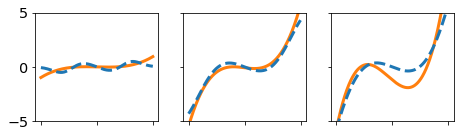

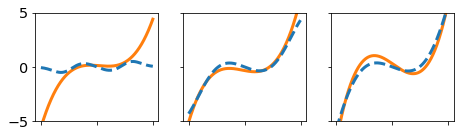

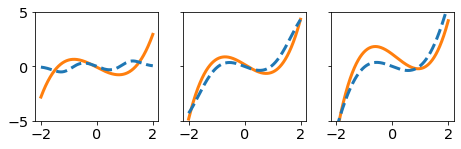

In [19]:
def V_tilde_prime(x, sigma):
    if abs(x) > 2:
        return x**3 - x
    else:
        return (x**3 - x) / i0(x**2 / (2*sigma))**2 + x / i0(x**2 / (2*sigma))**3 * i1(x**2 / (2*sigma))

r = 3
for j, epsilon in enumerate(epsilon_list):
    fig, ax = plt.subplots(1, 3)
    for k, sigma in enumerate(sigma_list):
        A_new = np.load(f"./Paper Data/experiment3-ma-42-{j}-{k}.npy")

        x = np.linspace(-2, 2, 500)
        ax[k].plot(x, np.sum(A_new[:, None]*np.array([x**i for i in range(r+1)]), axis=0), label="Approximation $\widetilde b$", linewidth=3, color='C1')
        ax[k].plot(x, [V_tilde_prime(xi, sigma) for xi in x], label="Exact $b$", linewidth=3, linestyle='dashed', color='C0')
        
        ax[k].set_ylim(-5, 5)
        if k > 0:
            ax[k].set_yticklabels([])
        if j < 2:
            ax[k].set_xticklabels([])
    fig.set_size_inches(7.5, 2)
    #plt.savefig(f'./Paper Figures/experiment3-ma-42-{j}.pdf', bbox_inches='tight')
    plt.show()

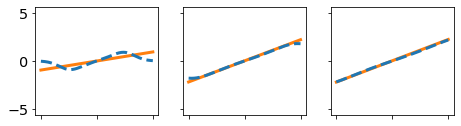

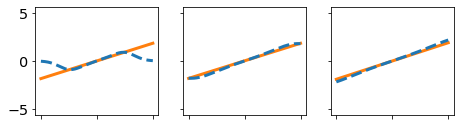

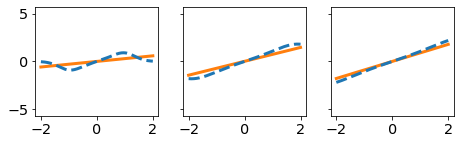

In [26]:
def V_tilde_prime(x, sigma): # grad V, alpha = (1/4, 1/2)
    if abs(x) > 2:
        return x
    else:
        return x / i0(x**2 / (2*sigma))**2 + x / i0(x**2 / (2*sigma))**3 * i1(x**2 / (2*sigma))

r = 1
for j, epsilon in enumerate(epsilon_list):
    fig, ax = plt.subplots(1, 3)
    for k, sigma in enumerate(sigma_list):
        A_new = np.load(f"./Paper Data/experiment3-ma-2-{j}-{k}.npy")

        x = np.linspace(-2, 2, 500)
        ax[k].plot(x, np.sum(A_new[:, None]*np.array([x**i for i in range(r+1)]), axis=0), label="Approximation $\widetilde b$", linewidth=3, color='C1')
        ax[k].plot(x, [V_tilde_prime(xi, sigma) for xi in x], label="Exact $b$", linewidth=3, linestyle='dashed', color='C0')
        
        ax[k].set_ylim(-5.7, 5.7)
        if k > 0:
            ax[k].set_yticklabels([])
        if j < 2:
            ax[k].set_xticklabels([])
    fig.set_size_inches(7.5, 2)
    #plt.savefig(f'./Paper Figures/experiment3-ma-2-{j}.pdf', bbox_inches='tight')
    plt.show()

In [20]:
def V_tilde_prime(x, sigma):
    if abs(x) > 2:
        return x**3 - x
    else:
        return (x**3 - x) / i0(x**2 / (2*sigma))**2 + x / i0(x**2 / (2*sigma))**3 * i1(x**2 / (2*sigma))

@nb.njit
def multiscale(epsilon, sigma, X0, T, n):

    dt = T / n
    sqrt_dt = np.sqrt(dt)
    sqrt_2sigma = np.sqrt(2 * sigma)
    sd = sqrt_dt * sqrt_2sigma
    Y = np.zeros(n+1)
    t_ = -dt

    for i, t in enumerate(np.linspace(0, T, n+1)):
        if i == 0:
            Y[i] = X0
        else:
            Y[i] = Y[i-1] - (
                    Y[i-1]**3 - Y[i-1] + (
                        Y[i-1] * np.cos(Y[i-1] / epsilon) - Y[i-1]**2 / (2*epsilon) * np.sin(Y[i-1] / epsilon)
                    ) * (np.abs(Y[i-1]) <= 2)
                ) * dt + sd * np.random.normal()
        
        t_ = t
    
    return Y

In [21]:
T = 5*10**4 # Large T important!
n = 5*10**7
dt = T / n

Y1 = multiscale(0.1, 0.5, 0, T, n)
Y2 = multiscale(0.25, 0.5, 0, T, n)
Y3 = multiscale(0.5, 0.5, 0, T, n)

In [22]:
np.min(Y1), np.max(Y1), np.min(Y2), np.max(Y2), np.min(Y3), np.max(Y3)

(-2.3388698343721694,
 2.3769437761811893,
 -2.515787853916714,
 2.4186848375566465,
 -2.513306403584039,
 2.478226532375863)

In [23]:
def V_tilde_prime(x, sigma): # grad V, alpha = (1/4, 1/2)
    if abs(x) > 2:
        return x
    else:
        return x / i0(x**2 / (2*sigma))**2 + x / i0(x**2 / (2*sigma))**3 * i1(x**2 / (2*sigma))


@nb.njit
def multiscale2(epsilon, sigma, X0, T, n):

    dt = T / n
    sqrt_dt = np.sqrt(dt)
    sqrt_2sigma = np.sqrt(2 * sigma)
    sd = sqrt_dt * sqrt_2sigma
    Y = np.zeros(n+1)
    t_ = -dt

    for i, t in enumerate(np.linspace(0, T, n+1)):
        if i == 0:
            Y[i] = X0
        else:
            Y[i] = Y[i-1] - (
                    Y[i-1] + (
                        Y[i-1] * np.cos(Y[i-1] / epsilon) - Y[i-1]**2 / (2*epsilon) * np.sin(Y[i-1] / epsilon)
                    ) * (np.abs(Y[i-1]) <= 2)
                ) * dt + sd * np.random.normal()
        
        t_ = t
    
    return Y


In [24]:
T = 5*10**4 # Large T important!
n = 5*10**7
dt = T / n

Y1 = multiscale(0.1, 0.5, 0, T, n)
Y2 = multiscale(0.25, 0.5, 0, T, n)
Y3 = multiscale(0.5, 0.5, 0, T, n)

In [25]:
np.min(Y1), np.max(Y1), np.min(Y2), np.max(Y2), np.min(Y3), np.max(Y3)

(-2.3531847669685977,
 2.305575733319102,
 -2.3959149545040175,
 2.5339565222116383,
 -2.513750022054727,
 2.4677387045019636)